In [1]:
from pathlib import Path
import cv2
import dlib
import numpy as np
import argparse
from contextlib import contextmanager
from keras.utils.data_utils import get_file
from wide_resnet import WideResNet
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D, Concatenate, Lambda
from keras.models import Model, Sequential
from keras import metrics
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt
import torch
from contextlib import contextmanager
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
def gen_vgg_model(num_classes,pretrained= True):

    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
 
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    
    if pretrained==True:
        
        model.load_weights('./models/vgg_face_weights.h5')
        
        for layer in model.layers[:-7]:
            layer.trainable = False



    base_model_output = Convolution2D(num_classes, (1, 1), name='predictions')(model.layers[-4].output)
    base_model_output = Flatten()(base_model_output)
    base_model_output = Activation('softmax')(base_model_output)
    base_model = Model(inputs=model.input, outputs=base_model_output)

    return base_model
    


In [3]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
   
    test_img = np.expand_dims(test_img, axis = 0)

    return test_img

In [7]:
#####Initialize Models  e.g 'vgg' or 'wide resnet'
model_name='wide_resnet'
if model_name=='vgg':
    age_model=gen_vgg_model(101)
    age_model.load_weights('./models/age_model_weights.h5')
    gender_model=gen_vgg_model(2)
    gender_model.load_weights('./models/gender_model_weights.h5')
    
    img_size=224
    print('models initialized')

elif model_name=='wide_resnet':
    model= WideResNet(64, depth=16, k=8)()
    model.load_weights('./models/weights.28-3.73.hdf5')
    
    img_size=64
    

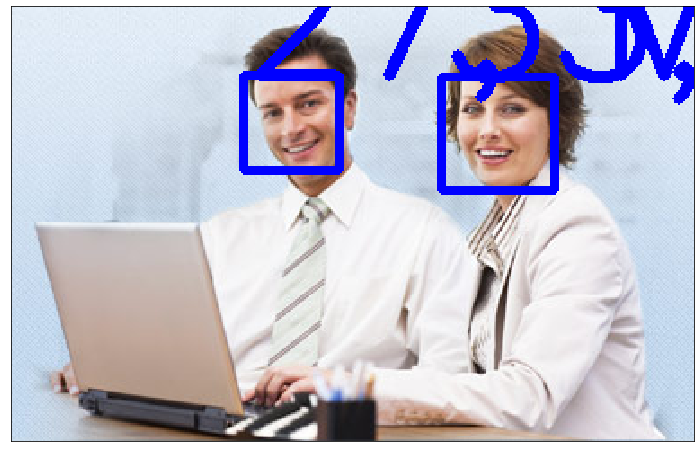

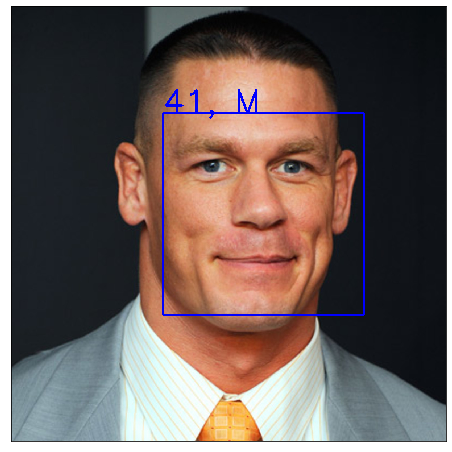

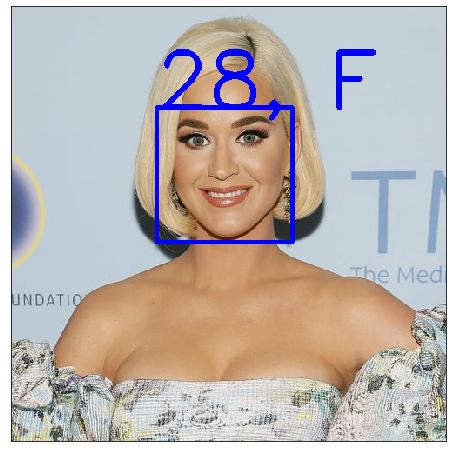

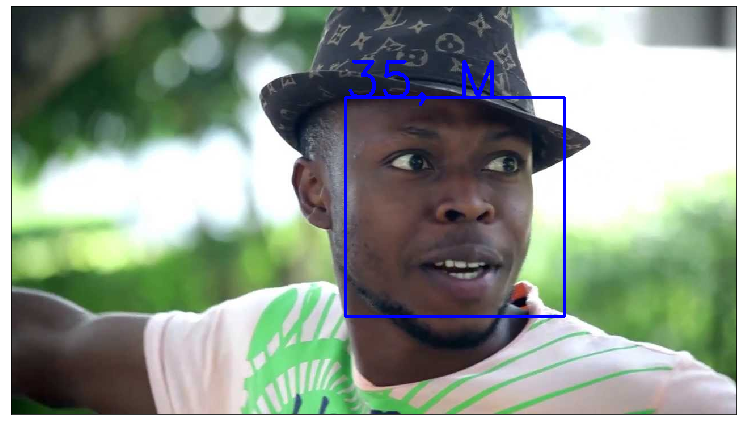

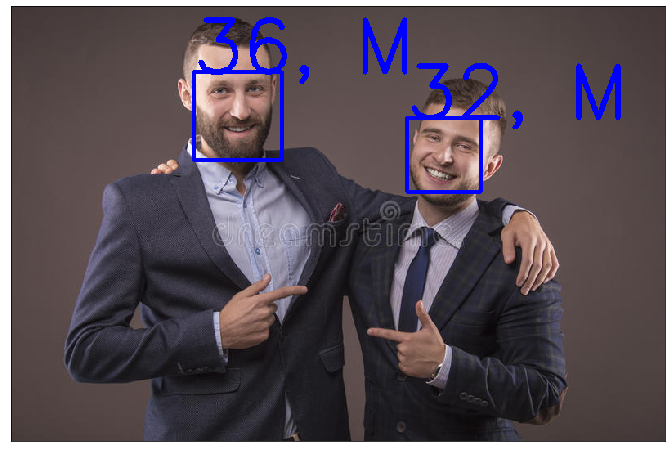

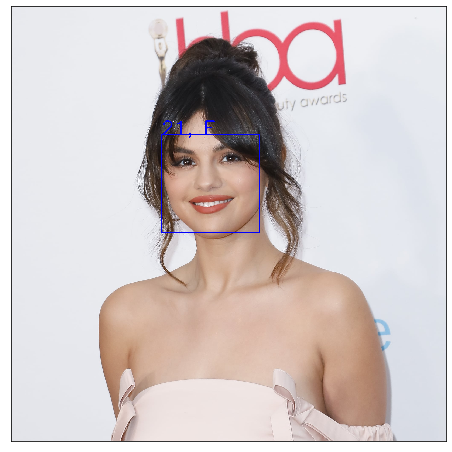

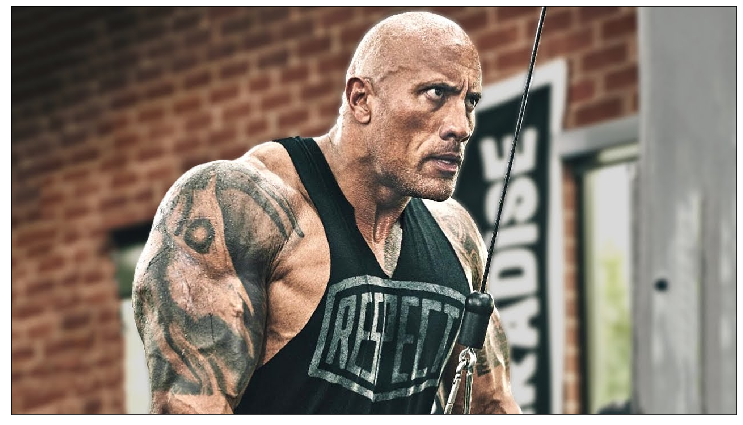

NameError: name 'cap' is not defined

In [9]:
import pdb
detector = dlib.get_frontal_face_detector()

margin=0.4

video=False
image_dir='./data/test_img'

@contextmanager

def video_capture(*args, **kwargs):
    cap = cv2.VideoCapture(*args, **kwargs)
    try:
        yield cap
    except KeyboardInterrupt:
        cap.release()
    finally:
        cap.release()

def yield_images():

    with video_capture(0) as cap:
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        while True:
            ret, img = cap.read()
            if not ret:

                raise RuntimeError("Failed to capture image")
            yield img


def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=3, thickness=2):


    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.putText(image, label, point, font, font_scale, (255, 0, 0), 5)



def yield_images_from_dir(image_dir):

    image_dir = Path(image_dir)



    for image_path in image_dir.glob("*.jpg*"):
      
        img = cv2.imread(str(image_path), 1)
        yield img


image_generator =  yield_images() if video  else   yield_images_from_dir('./data/test_img/')
k=0

for k, image in enumerate(image_generator) :
     
#     pdb.set_trace()
    img=cv2.resize(image, (img_size,img_size))
    input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_h, img_w, _ = np.shape(input_img)
    ih, iw, _ = np.shape(image)

    detected = detector(image, 1)
    faces = np.empty((len(detected), img_size, img_size, 3))
    for i, d in enumerate(detected):
        d=detected[i]
        x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()

        xw1 = max(int(x1 - margin * w), 0)

        yw1 = max(int(y1 - margin * h), 0)

        xw2 = min(int(x2 + margin * w), iw - 1)

        yw2 = min(int(y2 + margin * h), ih - 1)

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 4)

        faces[i, :, :, :] = cv2.resize(image[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))
        if model_name=='vgg':

            results_age = age_model.predict(np.expand_dims(faces[i,:,:,:],axis=0))
            predicted_genders=gender_model.predict(np.expand_dims(faces[i,:,:,:],axis=0))
        elif model_name=='wide_resnet':
            results=model.predict(np.expand_dims(faces[i,:,:,:],axis=0))
            results_age=results[1]
            predicted_genders=results[0]



        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results_age[0].dot(ages).flatten()

        label = "{}, {}".format(int(predicted_ages),"M" if np.argmax(predicted_genders)==1 else "F")
        draw_label(image, 
                   
                   (d.left(), d.top()), label)

    plt.figure(figsize=(13,8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()
#     clear_output(wait=True)

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
x = pd.DataFrame(columns= ["Error","Error_noise"])
x = 